<a href="https://colab.research.google.com/github/anushkahedaoo19/low_light_image_enhancement/blob/main/(3)_lenet%2Bunet_hybrid11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Step 1: Download the dataset
!gdown --id 157bjO1_cFuSd0HWDUuAmcHRJDVyWpOxB

# Step 2: Unzip the dataset
!unzip -q LOLdataset.zip -d /content/  # Extracting into /content/

# Step 3: Check the dataset structure
import os

DATASET_PATH = "/content/drive/MyDrive/image_data_set/LOLdataset/LOLdataset"  # Update this if the folder name is different

if os.path.exists(DATASET_PATH):
    print("✅ Dataset extracted successfully!")

    # Check folder structure
    print("Contents of dataset:", os.listdir(DATASET_PATH))

    # Define paths
    our485_path = os.path.join(DATASET_PATH, "our485")
    eval15_path = os.path.join(DATASET_PATH, "eval15")

    # Check if folders exist
    if os.path.exists(our485_path):
        print("Our485 - Low light images:", os.listdir(os.path.join(our485_path, "low"))[:5])
        print("Our485 - High light images:", os.listdir(os.path.join(our485_path, "high"))[:5])
    else:
        print("❌ Error: 'our485' folder not found!")

    if os.path.exists(eval15_path):
        print("Eval15 - Low light images:", os.listdir(os.path.join(eval15_path, "low"))[:5])
        print("Eval15 - High light images:", os.listdir(os.path.join(eval15_path, "high"))[:5])
    else:
        print("❌ Error: 'eval15' folder not found!")

else:
    print("❌ Error: Dataset not found! Check if the ZIP file was downloaded correctly.")


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=157bjO1_cFuSd0HWDUuAmcHRJDVyWpOxB
From (redirected): https://drive.google.com/uc?id=157bjO1_cFuSd0HWDUuAmcHRJDVyWpOxB&confirm=t&uuid=d363da80-1f12-4fdb-a02a-4ba91d158ff8
To: /content/LOLdataset.zip
100% 347M/347M [00:04<00:00, 77.2MB/s]
✅ Dataset extracted successfully!
Contents of dataset: ['eval15', 'our485', '__MACOSX']
Our485 - Low light images: ['100.png', '10.png', '.DS_Store', '101.png', '102.png']
Our485 - High light images: ['.DS_Store', '10.png', '101.png', '102.png', '103.png']
Eval15 - Low light images: ['179.png', '111.png', '22.png', '146.png', '23.png']
Eval15 - High light images: ['1.png', '55.png', '547.png', '179.png', '23.png']


In [ ]:
# Set the dataset base path
DATASET_PATH = "/content/drive/MyDrive/image_data_set/LOLdataset/LOLdataset"

# Define paths for low-light and normal-light images
TRAIN_LOW_PATH = os.path.join(DATASET_PATH, "our485", "low")   # Training low-light images
TRAIN_HIGH_PATH = os.path.join(DATASET_PATH, "our485", "high") # Training normal-light images

TEST_LOW_PATH = os.path.join(DATASET_PATH, "eval15", "low")   # Testing low-light images
TEST_HIGH_PATH = os.path.join(DATASET_PATH, "eval15", "high") # Testing normal-light images


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from skimage.restoration import denoise_wavelet
from skimage.metrics import structural_similarity as ssim


In [ ]:
TRAIN_LOW_PATH = "/content/our485/low"
TRAIN_HIGH_PATH = "/content/our485/high"
TEST_LOW_PATH = "/content/eval15/low"
TEST_HIGH_PATH = "/content/eval15/high"

IMG_SIZE = (256, 256)  # Image size for training


In [ ]:
def load_images(folder, img_size=IMG_SIZE):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize to [0,1]
            images.append(img)
    return np.array(images)

# Load images
train_low = load_images(TRAIN_LOW_PATH)
train_high = load_images(TRAIN_HIGH_PATH)
test_low = load_images(TEST_LOW_PATH)
test_high = load_images(TEST_HIGH_PATH)


In [ ]:
!pip install PyWavelets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 94.5 MB/s eta 0:00:00


In [ ]:
def wavelet_denoising(img):
    return denoise_wavelet(img, channel_axis=-1, convert2ycbcr=True, method='BayesShrink', mode='soft')

train_low = np.array([wavelet_denoising(img) for img in train_low])
test_low = np.array([wavelet_denoising(img) for img in test_low])


In [ ]:
def unet_model(input_shape=(256, 256, 3)):
    inputs = Input(input_shape)

    # Encoder (Similar to LeNet)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)

    # Decoder (Upsampling)
    u1 = UpSampling2D((2, 2))(c4)
    m1 = Concatenate()([u1, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(m1)

    u2 = UpSampling2D((2, 2))(c5)
    m2 = Concatenate()([u2, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(m2)

    u3 = UpSampling2D((2, 2))(c6)
    m3 = Concatenate()([u3, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(m3)

    # Output Layer
    outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(c7)

    model = Model(inputs, outputs)
    return model


In [ ]:
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))


In [ ]:
model = unet_model()
model.compile(optimizer='adam', loss=ssim_loss, metrics=['accuracy'])


In [ ]:
history = model.fit(train_low, train_high, epochs=50, batch_size=8, validation_split=0.2)


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 64s 772ms/step - accuracy: 0.3773 - loss: 0.3894 - val_accuracy: 0.4613 - val_loss: 0.2213
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 234ms/step - accuracy: 0.5725 - loss: 0.2265 - val_accuracy: 0.6921 - val_loss: 0.1932
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 237ms/step - accuracy: 0.6997 - loss: 0.1956 - val_accuracy: 0.7059 - val_loss: 0.1809
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 239ms/step - accuracy: 0.7270 - loss: 0.1822 - val_accuracy: 0.7494 - val_loss: 0.1813
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 246ms/step - accuracy: 0.7041 - loss: 0.1774 - val_accuracy: 0.7128 - val_loss: 0.1818
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 237ms/step - accuracy: 0.7236 - loss: 0.1878 - val_accuracy: 0.7065 - val_loss: 0.1786
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 243ms/step - accuracy: 0.7047 - loss: 0.1723 - val_accuracy: 0.6235 - val_loss: 0.1737
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 239ms/step - accuracy: 0.7181 - loss: 0.1699 - val_accu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Mounted at /content/drive
TypeError encountered: string indices must be integers, not 'str'
Trying to load without compilation...
Original Image Dimensions (length, breadth, channel): (1308, 736, 3)
Original Image Memory: 2820.38 KB
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
Enhanced Image Dimensions (length, breadth, channel): (1308, 736, 3)
Enhanced Image Memory: 2820.38 KB
Enhanced image saved successfully!

--- Image Enhancement Metrics ---
MSE: 103.0098, MSE (dB): 20.1288 dB
RMSE: 10.1494, RMSE (dB): 10.0644 dB
PSNR: 8.5078 dB
SSIM: 0.3434, SSIM Error (1-SSIM) (dB): -1.8272 dB
DSSIM: 0.3283, DSSIM (dB): -4.8375 dB


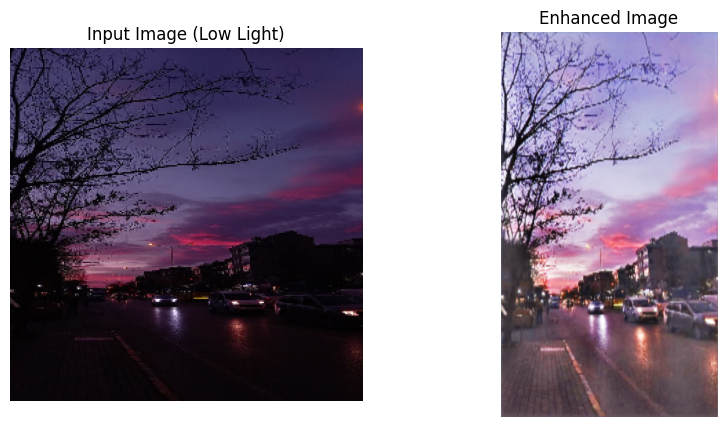

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
from google.colab import drive
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define Google Drive path for the model
model_path = '/content/drive/MyDrive/Train_model/low_light_enhancement_unet.h5'

# Load the trained model safely
try:
    custom_objects = {'MeanSquaredError': MeanSquaredError}
    model = load_model(model_path, custom_objects=custom_objects)
except TypeError as e:
    print(f"TypeError encountered: {e}")
    print("Trying to load without compilation...")
    model = load_model(model_path, compile=False)  # Load without compilation

# Function to compute MSE
def compute_mse(original, enhanced):
    return np.mean((original - enhanced) ** 2)

# Function to compute RMSE
def compute_rmse(original, enhanced):
    return np.sqrt(compute_mse(original, enhanced))

# Function to compute PSNR
def compute_psnr(original, enhanced):
    return psnr(original, enhanced, data_range=255)

# Function to compute SSIM and DSSIM
def compute_ssim_dssim(original, enhanced):
    ssim_index, _ = ssim(original, enhanced, data_range=255, full=True, win_size=7, channel_axis=-1)
    dssim_index = (1 - ssim_index) / 2
    return ssim_index, dssim_index

# Function to compute image memory size
def compute_memory_size(image):
    return image.nbytes / 1024  # Convert to KB

# Function to convert a metric to dB
def to_db(metric):
    if metric <= 0:  # Avoid log(0) or negative values
        return float('-inf')
    return 10 * np.log10(metric)

# Function to enhance a low-light image
def enhance_image(image_path, model):
    """Enhances an image using the trained model."""
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Unable to read image from {image_path}. Please check the file path and ensure it is a valid image.")

    # Original image dimensions and memory
    original_dims = img.shape  # (height, width, channels)
    original_memory = compute_memory_size(img)
    print(f"Original Image Dimensions (length, breadth, channel): {original_dims}")
    print(f"Original Image Memory: {original_memory:.2f} KB")

    # Resize image for model input
    img_resized = cv2.resize(img, (256, 256))
    img_norm = img_resized / 255.0  # Normalize pixel values
    img_norm = np.expand_dims(img_norm, axis=0)  # Add batch dimension

    # Predict the enhanced image
    enhanced_img = model.predict(img_norm)
    enhanced_img = np.squeeze(enhanced_img, axis=0)  # Remove batch dimension
    enhanced_img = (enhanced_img * 255).astype(np.uint8)  # Convert back to uint8 format

    # Resize back to original size
    enhanced_img = cv2.resize(enhanced_img, (original_dims[1], original_dims[0]))
    enhanced_memory = compute_memory_size(enhanced_img)
    print(f"Enhanced Image Dimensions (length, breadth, channel): {enhanced_img.shape}")
    print(f"Enhanced Image Memory: {enhanced_memory:.2f} KB")

    return img, enhanced_img

# Define input image path
input_image_path = '/content/drive/MyDrive/Train_model/3.jpg'

# Enhance the image
original_image, enhanced_image = enhance_image(input_image_path, model)

# Save the enhanced image
output_image_path = '/content/enhanced_image.jpg'
cv2.imwrite(output_image_path, enhanced_image)
print("Enhanced image saved successfully!")

# Resize original image to match enhanced image for metric calculations
original_resized = cv2.resize(original_image, (enhanced_image.shape[1], enhanced_image.shape[0]))

# Compute metrics
mse_value = compute_mse(original_resized, enhanced_image)
rmse_value = compute_rmse(original_resized, enhanced_image)
psnr_value = compute_psnr(original_resized, enhanced_image)
ssim_value, dssim_value = compute_ssim_dssim(original_resized, enhanced_image)

# Convert metrics to dB where applicable
mse_db = to_db(mse_value)
rmse_db = to_db(rmse_value)
ssim_error = 1 - ssim_value  # SSIM error (1 - SSIM)
ssim_error_db = to_db(ssim_error) if ssim_error > 0 else float('-inf')
dssim_db = to_db(dssim_value)

# Display computed metrics
print("\n--- Image Enhancement Metrics ---")
print(f"MSE: {mse_value:.4f}, MSE (dB): {mse_db:.4f} dB")
print(f"RMSE: {rmse_value:.4f}, RMSE (dB): {rmse_db:.4f} dB")
print(f"PSNR: {psnr_value:.4f} dB")
print(f"SSIM: {ssim_value:.4f}, SSIM Error (1-SSIM) (dB): {ssim_error_db:.4f} dB")
print(f"DSSIM: {dssim_value:.4f}, DSSIM (dB): {dssim_db:.4f} dB")

# Load the input image for display
input_image = cv2.imread(input_image_path)
input_image = cv2.resize(input_image, (256, 256))

# Display images side by side using Matplotlib
plt.figure(figsize=(10, 5))

# Display input image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct colors
plt.title('Input Image (Low Light)')
plt.axis('off')

# Display enhanced image
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2RGB))
plt.title('Enhanced Image')
plt.axis('off')

plt.show()